<a href="https://colab.research.google.com/github/SalhaAlzahrani/ConvAttenMixer/blob/main/VisionTransfomers_MRI_Brain_Tumor_Classification_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔵 Image classification with Vision Transformers

# 🧠 MRI Brain Tumor Classification

# Requirmenets

In [ ]:
!pip install tensorflow-addons tensorflow timm nilearn datasets transformers evaluate tfswin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 86.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 114.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.6 MB/s eta 0:

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras.metrics
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.optimizers import SGD,Adam
from keras import layers, models

from google.colab import drive
import tensorflow_addons as tfa
from tfswin import SwinTransformerTiny224, SwinTransformerV2Tiny256, preprocess_input

# Define the path to the MRI data directory
drive.mount('/content/drive', force_remount=True)

# Configure the hyperparameters


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
label_smoothing = 0.1

BATCH_SIZE = 32
IMG_SIZE = 224
NUM_CLASSES = 4
input_shape = (224, 224, 3)
NUM_EPOCHS = 30

# Prepare the data

In [ ]:
# train data
train_ds = image_dataset_from_directory(
    directory='/content/drive/MyDrive/Brain Tumor MRI/data/Training/',
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    shuffle=True,
    seed=1024,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

# validation data
val_ds = image_dataset_from_directory(
    directory='/content/drive/MyDrive/Brain Tumor MRI/data/Testing/',
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    shuffle=True,
    seed=1024,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [ ]:
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)



---


# SwinTransformerV2Tiny256

In [ ]:
inputs = layers.Input(shape=input_shape, dtype='uint8')
outputs = layers.Lambda(preprocess_input)(inputs)
outputs = SwinTransformerV2Tiny256(include_top=False, pooling='avg')(outputs)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(outputs)

model = models.Model(inputs=inputs, outputs=outputs)

113653888/113653888 [==============================] - 8s 0us/step


In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro', threshold=0.5),
    ],
)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS)

Epoch 1/30
179/179 [==============================] - 420s 2s/step - loss: 1.2894 - accuracy: 0.4366 - precision_4: 0.6623 - recall_4: 0.1675 - f1_score: 0.2134 - val_loss: 1.1522 - val_accuracy: 0.5179 - val_precision_4: 0.7249 - val_recall_4: 0.2593 - val_f1_score: 0.2697
Epoch 2/30
179/179 [==============================] - 39s 218ms/step - loss: 1.1252 - accuracy: 0.5480 - precision_4: 0.7480 - recall_4: 0.2899 - f1_score: 0.3374 - val_loss: 1.2275 - val_accuracy: 0.5362 - val_precision_4: 0.5761 - val_recall_4: 0.4477 - val_f1_score: 0.4041
Epoch 3/30
179/179 [==============================] - 39s 218ms/step - loss: 1.1107 - accuracy: 0.5606 - precision_4: 0.7364 - recall_4: 0.3209 - f1_score: 0.3884 - val_loss: 1.1385 - val_accuracy: 0.5271 - val_precision_4: 0.6636 - val_recall_4: 0.3265 - val_f1_score: 0.4203
Epoch 4/30
179/179 [==============================] - 39s 217ms/step - loss: 1.0020 - accuracy: 0.6537 - precision_4: 0.7571 - recall_4: 0.4758 - f1_score: 0.5496 - val_lo

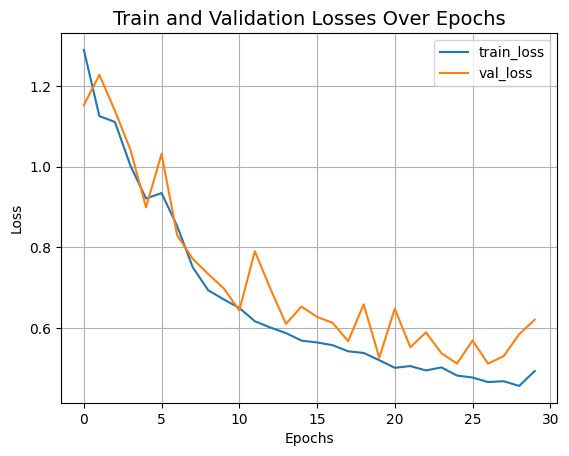

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()



---


# SwinTransformerTiny224

In [ ]:
inputs = layers.Input(shape=input_shape, dtype='uint8')
outputs = layers.Lambda(preprocess_input)(inputs)
outputs = SwinTransformerTiny224(include_top=False, pooling='avg')(outputs)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(outputs)

model = models.Model(inputs=inputs, outputs=outputs)

In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro', threshold=0.5),
    ],
)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS)

Epoch 1/30
179/179 [==============================] - 61s 212ms/step - loss: 1.3357 - accuracy: 0.3974 - precision_5: 0.5809 - recall_5: 0.1779 - f1_score: 0.2236 - val_loss: 1.2587 - val_accuracy: 0.4699 - val_precision_5: 0.6586 - val_recall_5: 0.1457 - val_f1_score: 0.1640
Epoch 2/30
179/179 [==============================] - 32s 177ms/step - loss: 1.1888 - accuracy: 0.5077 - precision_5: 0.6955 - recall_5: 0.2383 - f1_score: 0.2899 - val_loss: 1.2277 - val_accuracy: 0.4752 - val_precision_5: 0.6312 - val_recall_5: 0.3760 - val_f1_score: 0.3327
Epoch 3/30
179/179 [==============================] - 32s 177ms/step - loss: 1.1388 - accuracy: 0.5527 - precision_5: 0.7225 - recall_5: 0.3118 - f1_score: 0.3869 - val_loss: 1.2376 - val_accuracy: 0.4577 - val_precision_5: 0.5490 - val_recall_5: 0.3593 - val_f1_score: 0.3005
Epoch 4/30
179/179 [==============================] - 32s 177ms/step - loss: 1.0892 - accuracy: 0.5805 - precision_5: 0.7294 - recall_5: 0.3648 - f1_score: 0.4385 - val_

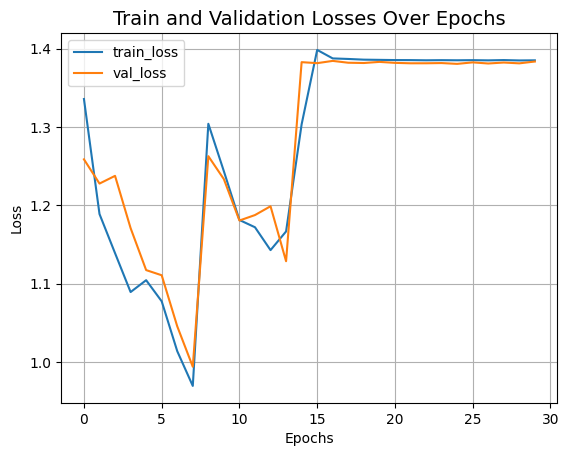

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()



---

# ⏰ Flush memory varibales before using the next transfomer

In [ ]:
del history
del model
del optimizer

NameError: ignored